In [47]:
import json
from ultralytics import YOLO
import cv2
import numpy as np
import time

import torch
from matplotlib import pyplot as plt

"""conda install -c conda-forge opencv"""

'conda install -c conda-forge opencv'

In [48]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    - box1: Tuple or List representing (x1, y1, x2, y2) of the first box.
    - box2: Tuple or List representing (x1, y1, x2, y2) of the second box.

    Returns:
    - IoU: Intersection over Union.
    """

    # Extract coordinates
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Calculate intersection coordinates
    x_intersection = max(0, min(x2_1, x2_2) - max(x1_1, x1_2))
    y_intersection = max(0, min(y2_1, y2_2) - max(y1_1, y1_2))

    # Calculate areas of boxes and intersection
    area_box1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area_box2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    area_intersection = x_intersection * y_intersection

    # Calculate Union
    area_union = area_box1 + area_box2 - area_intersection

    # Calculate IoU
    iou = area_intersection / (area_union + 1e-10)  # Add a small epsilon to avoid division by zero

    return iou

# Example usage:
box1 = (0, 0, 4, 4)
box2 = (2, 2, 6, 6)

iou = calculate_iou(box1, box2)
print(f"IoU: {iou}")


IoU: 0.14285714285663267


In [70]:
class Back_number_recogniser:
    def __init__(self):
        self.numbers = {}
        pass
    def read_participants(self,classesFilePath):
        # Opening JSON file
        f = open(classesFilePath)
        
        
        self.number_to_name = {}
        # returns JSON object as 
        # a dictionary
        self.participants = json.load(f)
        for i in self.participants:
            self.number_to_name[i["race_rider_bib_number"]] = i["rider"]["first_name"] + " "+ i["rider"]["last_name"]
        # Closing file
        f.close()
        
    def load_detection_model(self, model_path = "C:/Users/Eigenaar/Documents/school_Quinten/unief_2023_2024/Masterthesis/implementatie/number_detection/number_detection_10epochs.pt"):
        device = torch.device("cuda")
        self.detection_model = YOLO(model_path)
        self.detection_model.to(device)
        
    def load_recognition_model(self, model_path = "C:/Users/Eigenaar/Documents/school_Quinten/unief_2023_2024/Masterthesis/implementatie/number_recognition/number_recognition_10epochs.pt"):
        device = torch.device("cuda")
        self.recognition_model = YOLO(model_path)
        self.recognition_model.to(device)
        
    def detect_numbers(self,image):
        
        results = self.detection_model(image,verbose=False)
        return results
    
    def add_bb(self, image, boxes):
        ret_image = np.copy(image)
        for i in boxes:
            top = tuple([int(i[0].item()),int(i[1].item())])
            bottom = tuple([int(i[2].item()),int(i[3].item())])
            cv2.rectangle(ret_image,top,bottom, (255,0,0), 2)
        return ret_image
    
    def crop_image(self, image, box):
        image_copy = np.copy(image)
        left = int(box[0].item())
        right = int(box[2].item())
        top = int(box[1].item())
        bottom = int(box[3].item())
        cropped_image = image_copy[ top:bottom, left:right] # Slicing to crop the image
        return cropped_image
    
    def deinterlace_image(self, image):
        ret_image = np.copy(image)
        for i in range(len(ret_image)//2):
            ret_image[2*i+1] = ret_image[2*i]
        return ret_image
    
    def recognise_numbers(self, image, bboxes):
        cropped_images = []
        for i in range(len(bboxes)):
            cropped_image = self.crop_image(image, bboxes[i])
            deinterlaced_image = self.deinterlace_image(cropped_image)
            cropped_images.append(deinterlaced_image)
        
        results = self.recognition_model(cropped_images, verbose=False)
        detected_numbers = []
        for i in range(len(results)):
            result = results[i].boxes
            numbers = []
            coords = []
            for j in range(len(result.cls)):
                numbers.append(result.cls[j].item())
                coords.append(result.xyxy[j][0].item())
            numbers_sorted = [x for _,x in sorted(zip(coords,numbers))]
            number = ''
            for j in numbers_sorted:
                number+= str(int(j))
            detected_numbers.append(number)
            print(f"numbers in cropped_image: {numbers} and with coordinates {coords}")
        return detected_numbers
        
        
    def annotate_image(self, image, boxes,numbers,threshold = 0.5):
        
        imH, imW, imC = image.shape
        annotated_image = self.add_bb(image, boxes)
        
        if len(boxes) != 0:
            for i in range(len(boxes)):
                
                classLabelText = numbers[i]
                left = int(boxes[i][0].item())
                top = int(boxes[i][1].item())
                cv2.putText(annotated_image, classLabelText, (left, top-10), cv2.FONT_HERSHEY_PLAIN, 1, [0,0,255],2)
                
        return annotated_image

    def search_names(self, numbers):
        names= []
        for i in numbers:
            if int(i) in self.number_to_name:
                names.append(self.number_to_name[int(i)])
        return names

    def match_box(self, box):
        left = int(box[0].item())
        right = int(box[2].item())
        top = int(box[1].item())
        bottom = int(box[3].item())
        box = (left, top, right, bottom)
        print(box)
        print(self.numbers)
        match = False
        if len(self.numbers.keys()) != 0:
            for key in self.numbers:
                print(calculate_iou(box, key))
                if calculate_iou(box, key) >0.5:
                    match = True
                    print("match")
        if not match:
            print("new_box")
            self.numbers[box] = {}
                
        
    def predict_image(self,image):
        results = self.detect_numbers(image)
        boxes = results[0].boxes.xyxy
        if len(boxes) != 0:
            boxed_image = self.add_bb(image, boxes)
            detected_numbers = self.recognise_numbers(image,boxes)
            annotated_image = self.annotate_image(image, boxes, detected_numbers)
            return annotated_image, boxes, detected_numbers
        else:
            return image, [], []
    
    def process_image(self,imagePath):
        image = cv2.imread(imagePath)
        annotated_image, boxes, numbers = self.predict_image(image)
        # cv2.imshow("result", annotated_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        return annotated_image
    
    def process_video(self,videoPath,outputfile,startpoint = 0):
        cap = cv2.VideoCapture(videoPath)
        cap.set(cv2.CAP_PROP_POS_FRAMES, startpoint)
        # Check if the video capture was successful
        if not cap.isOpened():
            print("Error: Could not open the video file.")
            exit()
        ret, frame = cap.read()
        frame_width = int(frame.shape[1]) 
        frame_height = int(frame.shape[0])
        size = (frame_width, frame_height)
        #result = cv2.VideoWriter(outputfile,  cv2.VideoWriter_fourcc(*'MJPG'), 25, size) 
        # used to record the time when we processed last frame 
        prev_frame_time = time.time() 
        framenr = 0
        # used to record the time at which we processed current frame 
        new_frame_time = 0
        while True:
            ret, frame = cap.read()
            processed_frame, boxes, numbers = self.predict_image(frame)
            if len(boxes)!=0:
                for i in range(len(boxes)):
                    self.match_box(boxes[i])
            # font which we will be using to display FPS 
            font = cv2.FONT_HERSHEY_SIMPLEX 
            # time when we finish processing for this frame 
            new_frame_time = time.time() 
          
            # Calculating the fps 
          
            # fps will be number of frame processed in given time frame 
            # since their will be most of time error of 0.001 second 
            # we will be subtracting it to get more accurate result 
            fps = 1/(new_frame_time-prev_frame_time) 
            prev_frame_time = new_frame_time 
          
            # converting the fps into integer 
            fps = int(fps) 
          
            # converting the fps to string so that we can display it on frame 
            # by using putText function 
            fps = str(fps) 
          
            # putting the FPS count on the frame 
            cv2.putText(processed_frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA) 
            plt.imshow(processed_frame)
            plt.show()
            framenr+=1
            if framenr >2:
                break
            #result.write(processed_frame)
            #cv2.imshow('frame', processed_frame)
            
            #if cv2.waitKey(1) == ord('q'):
             #   break
        cap.release()
        #result.release()
        #cv2.destroyAllWindows()

numbers in cropped_image: [4.0, 1.0] and with coordinates [24.398839950561523, 7.0847649574279785]
numbers in cropped_image: [4.0, 1.0] and with coordinates [27.706283569335938, 2.6421453952789307]
numbers in cropped_image: [9.0, 7.0] and with coordinates [13.974862098693848, 55.09971618652344]
numbers in cropped_image: [9.0, 7.0, 3.0, 1.0] and with coordinates [5.693550109863281, 51.82619857788086, 6.923342227935791, 56.20119094848633]
numbers in cropped_image: [6.0, 1.0] and with coordinates [15.372565269470215, 39.44511413574219]
numbers in cropped_image: [6.0] and with coordinates [10.735673904418945]
(630, 392, 679, 457)
{}
new_box
(705, 392, 761, 458)
{(630, 392, 679, 457): {}}
0.0
new_box
(1334, 449, 1434, 537)
{(630, 392, 679, 457): {}, (705, 392, 761, 458): {}}
0.0
0.0
new_box
(1458, 436, 1557, 526)
{(630, 392, 679, 457): {}, (705, 392, 761, 458): {}, (1334, 449, 1434, 537): {}}
0.0
0.0
0.0
new_box
(1105, 398, 1172, 459)
{(630, 392, 679, 457): {}, (705, 392, 761, 458): {}, (13

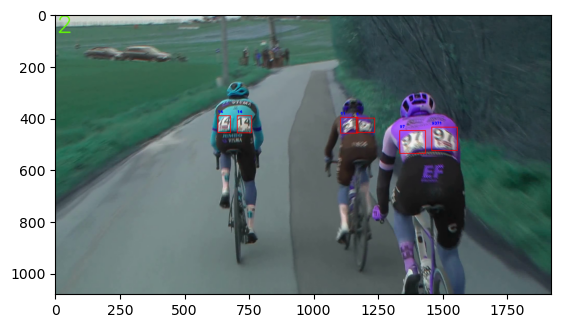

numbers in cropped_image: [9.0, 7.0] and with coordinates [15.603964805603027, 55.673126220703125]
numbers in cropped_image: [4.0, 1.0, 7.0] and with coordinates [25.433523178100586, 8.504220962524414, 8.606828689575195]
numbers in cropped_image: [4.0, 1.0] and with coordinates [29.680437088012695, 3.622948408126831]
numbers in cropped_image: [7.0, 9.0, 3.0] and with coordinates [54.674415588378906, 9.127110481262207, 9.490202903747559]
numbers in cropped_image: [6.0, 1.0] and with coordinates [10.532378196716309, 34.96150588989258]
numbers in cropped_image: [6.0] and with coordinates [13.123734474182129]
(1341, 457, 1443, 550)
{(630, 392, 679, 457): {}, (705, 392, 761, 458): {}, (1334, 449, 1434, 537): {}, (1458, 436, 1557, 526): {}, (1105, 398, 1172, 459): {}, (1166, 401, 1237, 456): {}}
0.0
0.0
0.6859671768393815
match
0.0
0.0
0.0
(627, 396, 675, 463)
{(630, 392, 679, 457): {}, (705, 392, 761, 458): {}, (1334, 449, 1434, 537): {}, (1458, 436, 1557, 526): {}, (1105, 398, 1172, 459): 

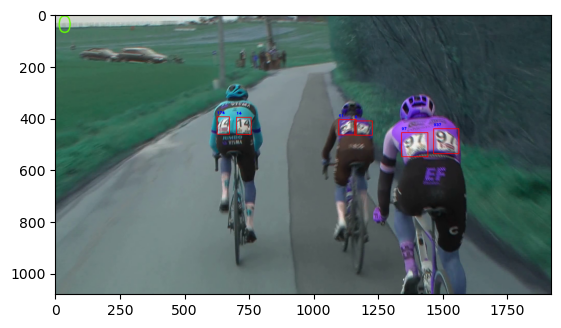

numbers in cropped_image: [6.0, 1.0] and with coordinates [12.47959041595459, 37.22564697265625]
numbers in cropped_image: [9.0, 7.0] and with coordinates [13.264359474182129, 56.826656341552734]
numbers in cropped_image: [7.0, 9.0] and with coordinates [54.984981536865234, 15.92597770690918]
numbers in cropped_image: [4.0] and with coordinates [24.53873634338379]
numbers in cropped_image: [4.0, 1.0] and with coordinates [28.3934383392334, 2.096273183822632]
numbers in cropped_image: [6.0] and with coordinates [9.862503051757812]
(1092, 416, 1157, 472)
{(630, 392, 679, 457): {}, (705, 392, 761, 458): {}, (1334, 449, 1434, 537): {}, (1458, 436, 1557, 526): {}, (1105, 398, 1172, 459): {}, (1166, 401, 1237, 456): {}}
0.0
0.0
0.0
0.0
0.407211801129113
0.0
new_box
(1471, 451, 1578, 550)
{(630, 392, 679, 457): {}, (705, 392, 761, 458): {}, (1334, 449, 1434, 537): {}, (1458, 436, 1557, 526): {}, (1105, 398, 1172, 459): {}, (1166, 401, 1237, 456): {}, (1092, 416, 1157, 472): {}}
0.0
0.0
0.0
0.

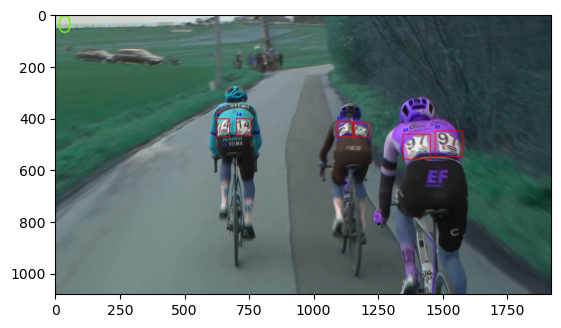

In [71]:

#image = "C:/Users/Eigenaar/Documents/school_Quinten/unief_2023_2024/Masterthesis/data/wva_foto.png"
#image = "C:/Users/Eigenaar/Documents/school_Quinten/unief_2023_2024/Masterthesis/implementatie/number_detection/data/images/e1948ebd-759b-11ee-bced-fcb3bc5cd112.jpg"
#image = "C:/Users/Eigenaar/Documents/school_Quinten/unief_2023_2024/Masterthesis/implementatie/number_detection/data/images/d2293da5-759a-11ee-b39f-fcb3bc5cd112.jpg"
#image = "C:/Users/Eigenaar/Documents/school_Quinten/unief_2023_2024/Masterthesis/implementatie/number_detection/data/images/d7a17471-759a-11ee-b7c3-fcb3bc5cd112.jpg"
#video = "C:/Users/Eigenaar/Documents/school_Quinten/unief_2023_2024/Masterthesis/implementatie/mt23/data/cut_rvv_1.mp4"
video = "data/cut_rvv_1.mov"
participant_file = "data/RVV23participants.json"
#participant_file = "data/OHN23 participants.json"
detection_path = "number_detection/runs/detect/train6/weights/best.pt" 
recognition_path = "number_recognition/runs/detect/train4/weights/best.pt"
outputfile = "data/new_results_cut_rvv_1.mp4"

recogniser = Back_number_recogniser()
recogniser.read_participants(participant_file)
recogniser.load_detection_model(detection_path)
recogniser.load_recognition_model(recognition_path)
recogniser.process_video(video,outputfile)
